# first example

Shallow water model for non-horizontal bottom $B(x)$ in conservative form (cons. variables: $h$, $uh=:m$)
\begin{align*}
h_t + m_x &= 0 \quad \text{conservation of volume/mass ($\rho$ is constant)}\\
m_t + (\frac{m^2}{h} + \frac{1}{2}gh^2)_x &= -ghB_x \quad \text{force/momentum balance in x}\\
\text{on } (x,t) \in [0,L] \times [0,\infty) &  \\
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

parameters

In [84]:
# parameters
L = 10
N = 320
dx = L/N
# T = 1
M = 1500

H = 1
g = 9.81
epsilon = 2*H
w = 0.1*L

a = 4.16667
a = 30
dt = dx/a
print(dt, dx)

0.0010416666666666667 0.03125


In [85]:
# in this notation u actually denotes the solution vector Q
def f(u):
    u_0 = u[1]
    u_1 = u[1] * u[1] / u[0] + 0.5 * g * u[0]*u[0]
    return np.array([u_0, u_1])

def RoeFlux(u,v):
    delta = u-v
    u_hat = (np.sqrt(u[0]) *u[1] / u[0] + np.sqrt(v[0]) * v[1] / v[0])
    u_hat = u_hat / (np.sqrt(u[0]) + np.sqrt(v[0]))
    # print(v[0])
    c_hat = np.sqrt(g * 0.5 * (v[0] + u[0]))
    alpha_1 = ((u_hat + c_hat)*delta[0] - delta[1] )/ (2*c_hat)
    alpha_2 = (-(u_hat - c_hat)*delta[0] + delta[1] )/ (2*c_hat)
    r_1 = np.array([1, u_hat - c_hat])
    r_2 = np.array([1, u_hat + c_hat])
    W_1 = alpha_1 * r_1
    W_2 = alpha_2 * r_2
    lambda_1 = u_hat - c_hat
    lambda_2 = u_hat + c_hat
    # lambda_2 = - lambda_1
    F = 0.5 * (f(v) + f(u)) - 0.5 * (abs(lambda_1) * W_1 + abs(lambda_2) * W_2)
    return F

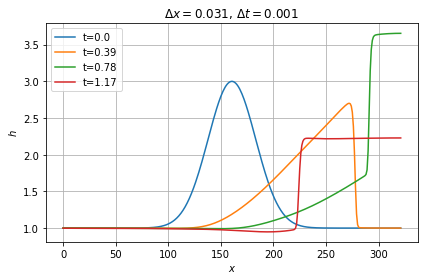

In [86]:
Q = np.zeros((N+2,M,2)) # N+2 space steps, M timesteps, 2 variables

# initial conditions
for k in np.arange(1,N+1):
    x = (2*k -1)/2 * dx
    Q[k,0,0] = H + epsilon * np.exp(-(x-L/2)**2 / w**2)
    # https://scicomp.stackexchange.com/questions/35062/shallow-water-equations-swe-well-posed-initial-data-for-single-travelling-pul
    Q[k,0,1] = -2*Q[k,0,0] * (np.sqrt(g)-np.sqrt(g*Q[k,0,0]))

for t in np.arange(1,M): # time loop 
    # ghost cells:
    Q[0,t-1,0] = Q[1,t-1,0]
    Q[0,t-1,1] = -Q[1,t-1,1] # for reflective BC with - sign
    Q[N+1,t-1,0] = Q[N,t-1,0]
    Q[N+1,t-1,1] = -Q[N,t-1,1] # for reflective BC with - sign

    for j in np.arange(1,N+1): # spatial loop
        # Q[j,t,:] = Q[j,t-1,:] - dt/dx*(RoeFlux(j,t-1) - RoeFlux(j-1,t))
        Q[j,t,:] = Q[j,t-1,:] - dt/dx*(RoeFlux(Q[j+1,t-1,:], Q[j,t-1,:]) - 
                                       RoeFlux(Q[j,t-1,:], Q[j-1,t-1,:]))

# plot
for k in np.arange(0,M):
    if k%(M/4)==0:
        plt.plot(Q[:,k,0], label = 't='+str(k*dt)[0:4])
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$h$")
# plt.ylim(0.95,1.3)
plt.title('$\Delta x=$'+str(dx)[:5]+', $\Delta t=$'+str(dt)[:5])#+", $C_0$="+str(C))
plt.legend()
plt.tight_layout()
# plt.savefig('plots/flat-highpulse-'+str(dt)[:5]+'-'+str(dx)[:5] + '.pdf')
plt.show()

# second example



In [45]:
# parameters
L = 10
N = 80
dx = L/N
# T = 15
M = 500
# a = N/250
# dt = T/M
dt = dx / (np.sqrt(g*H) * 3)
print(dt, dx)

H = 1
g = 9.81
epsilon = H/5
w = 0.1*L

# bump of bathymetry
B0 = H/10
r  = L/6

# IC/BC - factor of speed of cound
uK = 1.5

0.013303142850293768 0.125


In [46]:
# in this notation u actually denotes the solution vector Q = (h,m)^T
def f(u):
    u_0 = u[1]
    u_1 = u[1] * u[1] / u[0] + 0.5 * g * u[0]*u[0]
    return np.array([u_0, u_1])

def RoeFlux(u,v):
    delta = u-v
    u_hat = (np.sqrt(u[0]) *u[1] / u[0] + np.sqrt(v[0]) * v[1] / v[0])
    u_hat = u_hat / (np.sqrt(u[0]) + np.sqrt(v[0]))
    c_hat = np.sqrt(g * 0.5 * (v[0] + u[0]))
    alpha_1 = ((u_hat + c_hat)*delta[0] - delta[1] )/ (2*c_hat)
    alpha_2 = (-(u_hat - c_hat)*delta[0] + delta[1] )/ (2*c_hat)
    r_1 = np.array([1, u_hat - c_hat])
    r_2 = np.array([1, u_hat + c_hat])
    W_1 = alpha_1 * r_1
    W_2 = alpha_2 * r_2
    lambda_1 = u_hat - c_hat
    lambda_2 = u_hat + c_hat
    F = 0.5 * (f(v) + f(u)) - 0.5 * (abs(lambda_1) * W_1 + abs(lambda_2) * W_2)
    return F

def S(h,x):
    pi = np.pi
    if abs(x-L/2) < r:
        dBdx = B0*pi*np.sin(pi*(L-2*x)*0.25/r)*np.cos(pi*(L-2*x)*0.25/r)/r
        return np.array([0,-g*h*dBdx])
    else: return np.array([0,0])

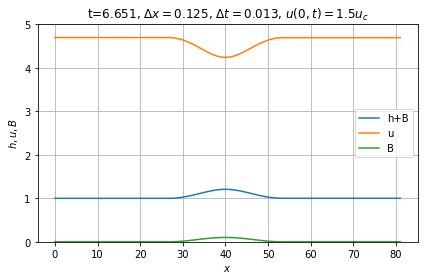

In [47]:
# N+2 space steps, M timesteps, 2 variables
Q = np.zeros((N+2,M,2))
# bottom
B = np.zeros(N+2)

# spatial loop for the bottom
for j in np.arange(1,N+1): 
    x = j*dx
    if abs(x - L/2) < r: B[j] = B0*np.cos(np.pi*(x-L/2)*0.5/r)**2
    else : B[j] = 0

# initial conditions
for k in np.arange(1,N+1):
    # take cell center value:
    Q[k,0,0] = H
    Q[k,0,1] = H*uK*np.sqrt(g*H)

# time loop 
for t in np.arange(1,M):
    # ghost cells:
    Q[0,t-1,0] = H#Q[1,t-1,0]
    Q[0,t-1,1] = H*uK*np.sqrt(g*H)
    Q[N+1,t-1,0] = Q[N,t-1,0]
    Q[N+1,t-1,1] = Q[N,t-1,1]

    # spatial loop
    for j in np.arange(1,N+1):
        x = (2*j-1)/2 *dx
        # adjusted scheme for non-horizontal bottom
        Q[j,t,:] = Q[j,t-1,:] - dt/dx*(RoeFlux(Q[j+1,t-1,:], Q[j,t-1,:]) - 
                                       RoeFlux(Q[j,t-1,:], Q[j-1,t-1,:])) + dt * S(Q[j,t-1,0], x)

# plot
plt.plot(Q[:,M-2,0]+B, label = "h+B")
plt.plot(Q[:,M-2,1]/Q[:,M-2,0], label = "u")
plt.plot(B, label="B")
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$h, u, B$")
plt.ylim(0,5)
plt.title('t='+str(M*dt)[:5]+', $\Delta x=$'+str(dx)[:5]+', $\Delta t=$'+str(dt)[:5]+', $u(0,t)=$'+str(uK)+'$u_c$')
plt.legend()
plt.tight_layout()
# plt.savefig('plots/bump-'+str(dx)[:5]+'-' +str(dt)[:5]+"-"+str(uK) + 'uc.pdf')
plt.show()

# third example: entropy fix

In [176]:
# parameters
L = 10
N = 160
dx = L/N
H = 1
g = 9.81
w = 0.1*L
epsilon = H/5
alpha = 1

delta = 1/0.6* dx
entropy_fix = True

M = 1500
#dt = 0.25*dx**2/(2*alpha)
dt = dx / (np.sqrt(g*H) * 3)

# IC/BC - factor of speed of cound
uK = 0.5

In [177]:
def f(u):
    u_0 = u[1]
    u_1 = u[1] * u[1] / u[0] + 0.5 * g * u[0]*u[0]
    return np.array([u_0, u_1])

def RoeFlux(u,v):
    delta = u-v
    u_hat = (np.sqrt(u[0]) *u[1] / u[0] + np.sqrt(v[0]) * v[1] / v[0])
    u_hat = u_hat / (np.sqrt(u[0]) + np.sqrt(v[0]))
    c_hat = np.sqrt(g * 0.5 * (v[0] + u[0]))
    alpha_1 = ((u_hat + c_hat)*delta[0] - delta[1] )/ (2*c_hat)
    alpha_2 = (-(u_hat - c_hat)*delta[0] + delta[1] )/ (2*c_hat)
    r_1 = np.array([1, u_hat - c_hat])
    r_2 = np.array([1, u_hat + c_hat])
    W_1 = alpha_1 * r_1
    W_2 = alpha_2 * r_2
    lambda_1 = u_hat - c_hat
    lambda_2 = u_hat + c_hat
    F = 0.5 * (f(v) + f(u)) - 0.5 * (Phi(lambda_1) * W_1 + Phi(lambda_2) * W_2)
    return F

def B(x):
    r = L/6
    B_0 = H/10
    B_hat = np.zeros(len(x))
    for j in range(0,len(x)):
        if abs(x[j] - L /2) < r:
            B_hat[j] = B_0 * ( np.cos(np.pi * (x[j]-L/2) / (2*r)) )**2
        else :
            B_hat[j] = 0
    return B_hat

def S(j,h):
    B_0 = H/10
    r = L/6
    x = (2*j - 1)/2 * dx
    
    if abs(x - L /2) < r:
        return np.array([0,- g*h* B_0 * np.pi/r * (-np.sin(np.pi * (x-L/2) / (2*r))) * np.cos(np.pi * (x-L/2) / (2*r))])
    else :
        return np.array([0,0])

def Phi(x):
    if entropy_fix == True:
        if abs(x) >= delta:
            return abs(x)
        else:
            return (x**2 + delta**2)/(2*delta)
    else:
        return abs(x)

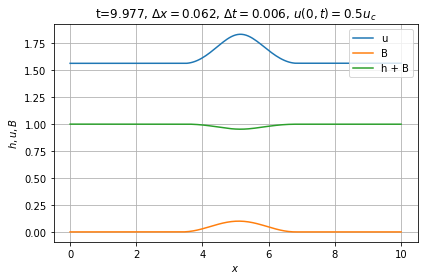

In [178]:
Q = np.zeros((N+2,M,2)) # N+2 space steps, M timesteps, 2 variables
B_hat = B(np.linspace(0,L,N+2))

# initial conditions
for k in np.arange(1,N+1):
    Q[k,0,0] = H
    Q[k,0,1] = H*uK * np.sqrt(g*H) #since u<np.sqrt(g*h(x)) and m = u*h
    #use Q[k,0,1] = H* 1.5 * np.sqrt(g*H) for super-critical and factor 0.5 for sub-critical
    #factors 0.65 for type 3 and 0.95 for type 4

for t in np.arange(1,M): # time loop 
    # ghost cells:
    Q[0,t-1,0] = H
    Q[0,t-1,1] = H*uK*np.sqrt(g*H) #use Q[k,0,1] = H* 1.5 * np.sqrt(g*H) for super-critical and factor 0.5 for sub-critical
    Q[N+1,t-1,0] = Q[N,t-1,0]
    Q[N+1,t-1,1] = Q[N,t-1,1]

    for j in np.arange(1,N+1): # spatial loop
        
        Q[j,t,:] = Q[j,t-1,:] - dt/dx*(RoeFlux(Q[j+1,t-1,:], Q[j,t-1,:]) - 
                                                         RoeFlux(Q[j,t-1,:], Q[j-1,t-1,:])) + dt * S(j,Q[j,t-1,0])

# plot
plt.plot(np.linspace(0,L,157),Q[1:158,M-1,1]/Q[1:158,M-1,0], label = "u")      
plt.plot(np.linspace(0,L,157),B_hat[1:158], label = "B")
plt.plot(np.linspace(0,L,157),B_hat[1:158] + Q[1:158,M-1,0], label = "h + B")
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$h, u, B$")
plt.title('t='+str(M*dt)[:5]+', $\Delta x=$'+str(dx)[:5]+', $\Delta t=$'+str(dt)[:5]+', $u(0,t)=$'+str(uK)+'$u_c$')
plt.legend()
plt.tight_layout()
# plt.savefig('plots/entropy-'+str(dx)[:5]+'-' +str(dt)[:5]+"-"+str(uK) + 'uc.pdf')
plt.show()

# fourth example: higher order scheme

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# parameters
L = 10
N = 80
dx = L/N
T = 3
M = 500
a = N/250
dt = T/(M*a)
print(dt, dx)

H = 1
g = 9.81
epsilon = H/5
# epsilon = 2*H
w = 0.1*L

# entropy fix
delta = 1/0.6* dx
entropy_fix = True

# bottom
B0 = H/10
r  = L/6

0.01875 0.125


In [36]:
# in this notation u actually denotes the solution vector Q
def f(u):
    u_0 = u[1]
    u_1 = u[1] * u[1] / u[0] + 0.5 * g * u[0]*u[0]
    return np.array([u_0, u_1])

def Phi(x):
    if entropy_fix == True:
        if abs(x) >= delta:
            return abs(x)
        else:
            return (x**2 + delta**2)/(2*delta)
    else:
        return abs(x)

def RoeFlux(u,v):
    delta = u-v
    if u[0] < 0: print("asdf")
    u_hat = (np.sqrt(u[0]) *u[1] / u[0] + np.sqrt(v[0]) * v[1] / v[0])
    u_hat = u_hat / (np.sqrt(u[0]) + np.sqrt(v[0]))
    c_hat = np.sqrt(g * 0.5 * (v[0] + u[0]))
    alpha_1 = ((u_hat + c_hat)*delta[0] - delta[1] )/ (2*c_hat)
    alpha_2 = (-(u_hat - c_hat)*delta[0] + delta[1] )/ (2*c_hat)
    r_1 = np.array([1, u_hat - c_hat])
    r_2 = np.array([1, u_hat + c_hat])
    W_1 = alpha_1 * r_1
    W_2 = alpha_2 * r_2
    lambda_1 = u_hat - c_hat
    lambda_2 = u_hat + c_hat
    F = 0.5 * (f(v) + f(u)) - 0.5 * (Phi(lambda_1) * W_1 + Phi(lambda_2) * W_2)
    # F = 0.5 * (f(v) + f(u)) - 0.5 * (abs(lambda_1) * W_1 + abs(lambda_2) * W_2)
    return F

def fluxlimiter(theta):
    if theta < 1: return max(0,theta)
    else:         return 1

alphas_1 = np.zeros(N+2)
alphas_2 = np.zeros(N+2)

# corrected high order flux
def RoeFlux_corr(u,v,j):
    # index1: water height h
    # index2: water momentum m
    
    # Wtilde see in Leveque eq. 6.55
    delta = u-v
    u_hat = (np.sqrt(u[0]) *u[1] / u[0] + np.sqrt(v[0]) * v[1] / v[0])
    u_hat = u_hat / (np.sqrt(u[0]) + np.sqrt(v[0]))
    c_hat = np.sqrt(g * 0.5 * (v[0] + u[0]))
    alphas_1[j] = ((u_hat + c_hat)*delta[0] - delta[1] )/ (2*c_hat)
    alphas_2[j] = (-(u_hat - c_hat)*delta[0] + delta[1] )/ (2*c_hat)
    lambda_1 = u_hat - c_hat
    lambda_2 = u_hat + c_hat
    
    if lambda_1 > 0: theta_1 = alphas_1[j-1]
    else           : theta_1 = alphas_1[j+1]
    if lambda_2 > 0: theta_2 = alphas_2[j-1]
    else           : theta_2 = alphas_2[j+1]
    alpha_tilde_1 = alphas_1[j]*fluxlimiter(theta_1)
    alpha_tilde_2 = alphas_2[j]*fluxlimiter(theta_2)
    r_1 = np.array([1, u_hat - c_hat])
    r_2 = np.array([1, u_hat + c_hat])
    Wtilde1 = alpha_tilde_1*r_1
    Wtilde2 = alpha_tilde_2*r_2

    # Ftilde see in Leveque eq. 15.63
    # lambda_l1 = ...
    # lambda_l2 = ...
    # lambda_r1 = ...
    # lambda_r2 = ...
    # s1 = 0.5 * abs(lambda_l1 + lambda_r1) # ?
    # s2 = 0.5 * abs(lambda_l2 + lambda_r2) # ?
    s1 = abs(lambda_1)
    s2 = abs(lambda_2)
    Ftilde1 = 0.5 * s1*(1-dt/dx*s1)*Wtilde1
    Ftilde2 = 0.5 * s2*(1-dt/dx*s2)*Wtilde2
    return Ftilde1 + Ftilde2

def S(h,x):
    pi = np.pi
    if abs(x-L/2) < r:
        dBdx = B0*pi*np.sin(pi*(L-2*x)*0.25/r)*np.cos(pi*(L-2*x)*0.25/r)/r
        return np.array([0,-g*h*dBdx])
    else: return np.array([0,0])

In [37]:
# N=6
# a = np.zeros(N+2)
# a[0] = 0
# a[N+1] = 0
# a[1] = 1
# a[N] = 1
# for i in range(2,N):
#     a[i] = 2

# print(a)

asdf
asdf
asdf
asdf


<ipython-input-36-143614e2dbd9>:19: RuntimeWarning: invalid value encountered in sqrt
  u_hat = (np.sqrt(u[0]) *u[1] / u[0] + np.sqrt(v[0]) * v[1] / v[0])
<ipython-input-36-143614e2dbd9>:20: RuntimeWarning: invalid value encountered in sqrt
  u_hat = u_hat / (np.sqrt(u[0]) + np.sqrt(v[0]))
<ipython-input-36-143614e2dbd9>:48: RuntimeWarning: invalid value encountered in sqrt
  u_hat = (np.sqrt(u[0]) *u[1] / u[0] + np.sqrt(v[0]) * v[1] / v[0])
<ipython-input-36-143614e2dbd9>:49: RuntimeWarning: invalid value encountered in sqrt
  u_hat = u_hat / (np.sqrt(u[0]) + np.sqrt(v[0]))
<ipython-input-36-143614e2dbd9>:19: RuntimeWarning: overflow encountered in double_scalars
  u_hat = (np.sqrt(u[0]) *u[1] / u[0] + np.sqrt(v[0]) * v[1] / v[0])
<ipython-input-36-143614e2dbd9>:4: RuntimeWarning: overflow encountered in double_scalars
  u_1 = u[1] * u[1] / u[0] + 0.5 * g * u[0]*u[0]
<ipython-input-36-143614e2dbd9>:48: RuntimeWarning: overflow encountered in double_scalars
  u_hat = (np.sqrt(u[0]) *u[

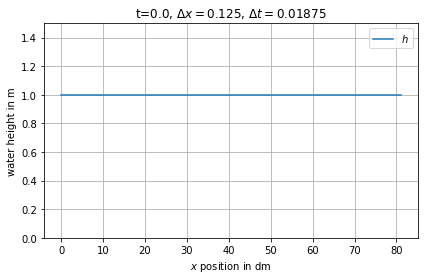

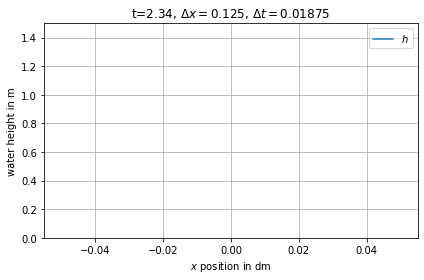

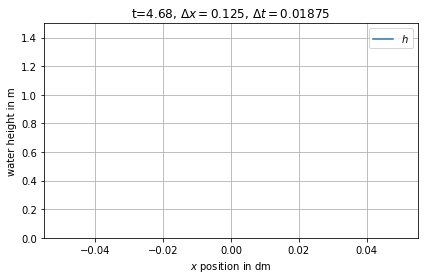

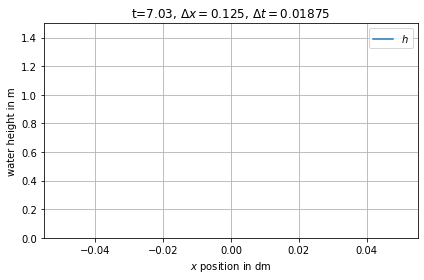

In [38]:
# N+2 space steps, M timesteps, 2 variables
Q = np.zeros((N+2,M,2))
# bottom
B = np.zeros(N+2)

# spatial loop for the bottom
for j in np.arange(1,N+1): 
    x = j*dx
    if abs(x - L/2) < r: B[j] = B0*np.cos(np.pi*(x-L/2)*0.5/r)**2
    else : B[j] = 0

# initial conditions
for k in np.arange(1,N+1):
    # take cell center value:
    Q[k,0,0] = H
    Q[k,0,1] = H*1.5*np.sqrt(g*H)

# time loop
for t in np.arange(1,M):
    # ghost cells:
    Q[0,t-1,0] = H#Q[1,t-1,0]
    Q[0,t-1,1] = H*1.5*np.sqrt(g*H)
    Q[N+1,t-1,0] = Q[N,t-1,0]
    Q[N+1,t-1,1] = Q[N,t-1,1]

    # first cell - no flux correction
    j = 1
    x = (2*j-1)/2 *dx
    Q[j,t,:] = Q[j,t-1,:] - dt/dx*(RoeFlux(Q[j+1,t-1,:], Q[j,t-1,:]) - 
                                   RoeFlux(Q[j,t-1,:], Q[j-1,t-1,:]) + dt * S(Q[j,t-1,0], x))
    # center cells - with flux correction
    for j in range(2,N):
        x = (2*j-1)/2 *dx
        Q[j,t,:] = Q[j,t-1,:] - dt/dx*(RoeFlux(Q[j+1,t-1,:], Q[j,t-1,:]) - 
                                       RoeFlux(Q[j,t-1,:], Q[j-1,t-1,:]) +
                                       RoeFlux_corr(Q[j+1,t-1,:], Q[j,t-1,:], j) - 
                                       RoeFlux_corr(Q[j,t-1,:], Q[j-1,t-1,:], j)) + dt * S(Q[j,t-1,0], x)
    # last cell - no flux correction
    j = N
    x = (2*j-1)/2 *dx
    Q[j,t,:] = Q[j,t-1,:] - dt/dx*(RoeFlux(Q[j+1,t-1,:], Q[j,t-1,:]) - 
                                   RoeFlux(Q[j,t-1,:], Q[j-1,t-1,:]) + dt * S(Q[j,t-1,0], x))

# print(Q[:,-1,0])

# plot
n = 1
for k in np.arange(0,M):
    if k%(M/4)==0:
        plt.plot(Q[:,k,0], label = "$h$")
        # plt.plot(Q[:,k,0)
        plt.grid()
        plt.xlabel("$x$ position in dm")
        plt.ylabel("water height in m")
        plt.ylim(0,1.5)
        plt.title('t='+str(k*dt)[0:4]+', $\Delta x=$'+str(dx)+', $\Delta t=$'+str(dt))#+", $C_0$="+str(C))
        plt.legend()
        plt.tight_layout()
        # plt.savefig('plots/damping'+str(dx)+'-' + str(n) + '.jpg')
        plt.show()
        n+=1